# PDLFC01 - is it a bird?

*Note: this is a kaggle notebook. Using it on Google Colab would require the installation of additional packages.*

The main parts of the following code are taken from this notebook

https://www.kaggle.com/code/jhoward/is-it-a-bird-creating-a-model-from-your-own-data

which is from the course "Practical Deep Learning for Coders".

Content:

- Performing a duckduckgo search for images of birds and forrest
- Download the results
- Train the model
- Use the model

## Basic installations

In [1]:
#NB: Kaggle requires phone verification to use the internet or a GPU. If you haven't done that yet, the cell below will fail
#    This code is only here to check that your internet is enabled. It doesn't do anything else.
#    Here's a help thread on getting your phone number verified: https://www.kaggle.com/product-feedback/135367

import socket,warnings
try:
    socket.setdefaulttimeout(1)
    socket.socket(socket.AF_INET, socket.SOCK_STREAM).connect(('1.1.1.1', 53))
except socket.error as ex: raise Exception("STOP: No internet. Click '>|' in top right and set 'Internet' switch to on")

**Note: The following messages from pip can be ignored:**

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.

In [ ]:
# It's a good idea to ensure you're running the latest version of any libraries you need.
# `!pip install -Uqq <libraries>` upgrades to the latest version of <libraries>
# NB: You can safely ignore any warnings or errors pip spits out about running as root or incompatibilities
import os
iskaggle = os.environ.get('KAGGLE_KERNEL_RUN_TYPE', '')

if iskaggle:
    !pip install -Uqq fastai duckduckgo_search

## Step 1: Search and download images of birds and non-birds

In [3]:
# rd: fixed version: 07.07.2024
# fix: https://github.com/andersglindstrom/download_ddg_birds/blob/main/download-ddg.ipynb

!pip install -Uqq duckduckgo-images-api
!pip install -Uqq fastbook

from fastbook import search_images_ddg
from fastcore.all import *
from fastdownload import download_url
from fastai.vision.all import *

def search_images(term, max_images=30):
    print(f"Searching for '{term}'")
    return search_images_ddg(term, max_images=max_images)

- Search for forest and bird.
- Serach in 3 variations (photo, sun photo, shade photo)
- Default: 30 results
- Download the images
- Resize all downloaded images 


In [4]:
searches = 'forest','bird'
path = Path('bird_or_not')
from time import sleep

for o in searches:
    dest = (path/o)
    dest.mkdir(exist_ok=True, parents=True)
    download_images(dest, urls=search_images(f'{o} photo'))
    sleep(10)  # Pause between searches to avoid over-loading server
    download_images(dest, urls=search_images(f'{o} sun photo'))
    sleep(10)
    download_images(dest, urls=search_images(f'{o} shade photo'))
    sleep(10)
    resize_images(path/o, max_size=400, dest=path/o)

Searching for 'forest photo'
Searching for 'forest sun photo'
Searching for 'forest shade photo'
Searching for 'bird photo'
Searching for 'bird sun photo'
Searching for 'bird shade photo'


## Step 2: Train the model

Remove photos which might not be download correctly.

In [5]:
failed = verify_images(get_image_files(path))
failed.map(Path.unlink)
len(failed)

2

`DataLoaders` = an object that contains a 
- *training set* (the images used to create a model) and a 
- *validation set* (the images used to check the accuracy of a model -- not used during training).

In fastai we can create that easily using a `DataBlock`

`show_batch`shows examples

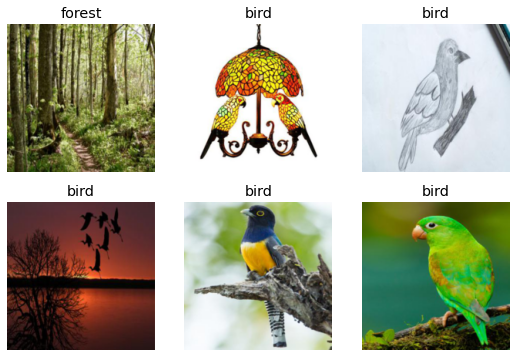

In [6]:
dls = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=[Resize(192, method='squish')]
).dataloaders(path, bs=32)

dls.show_batch(max_n=6)

**Explanations:**

Here what each of the `DataBlock` parameters means:

    blocks=(ImageBlock, CategoryBlock),

The inputs to our model are images, and the outputs are categories (in this case, "bird" or "forest").

    get_items=get_image_files, 

To find all the inputs to our model, run the `get_image_files` function (which returns a list of all image files in a path).

    splitter=RandomSplitter(valid_pct=0.2, seed=42),

Split the data into training and validation sets randomly, using 20% of the data for the validation set.

    get_y=parent_label,

The labels (`y` values) is the name of the `parent` folder of each file (i.e. the name of the folder they're in, which will be *bird* or *forest*).

    item_tfms=[Resize(192, method='squish')]

Before training, resize each image to 192x192 pixels by "squishing" it (as opposed to cropping it).

**Training:**

Now we train (fine-tune) the model using the pretrained computer vision model`resnet18`. It was trained to recognise photos in *imagenet*, and widely-used computer vision dataset with images covering 1000 categories.

`fastai` comes with a helpful `fine_tune()` method which automatically uses best practices for fine tuning a pre-trained model.

In [8]:
learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(3)

epoch,train_loss,valid_loss,error_rate,time
0,0.887622,0.571001,0.272727,00:01


epoch,train_loss,valid_loss,error_rate,time
0,0.175039,0.113780,0.060606,00:01
1,0.100862,0.072403,0.030303,00:01
2,0.074256,0.103047,0.030303,00:01


The `error_rate` should be 0.00 or near this value.

> "Fine-tuning" a model means that we're starting with a model someone else has trained using some other dataset (called the *pretrained model*), and adjusting the weights a little bit so that the model learns to recognise your particular dataset.

## Step 3: Use our model

Let's download a photo and use it for testing:

Searching for 'forrest in canada photos'


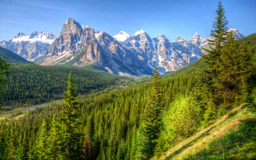

In [20]:
urls = search_images('forrest in canada photos', max_images=1)
dest = 'test.jpg'
download_url(urls[0], dest, show_progress=False)

from fastai.vision.all import *
im = Image.open(dest)
im.to_thumb(256,256)

In [21]:
is_bird,_,probs = learn.predict(PILImage.create('test.jpg'))
print(f"This is a: {is_bird}.")
print(f"Probability it's a bird: {probs[0]:.4f}")

This is a: forest.
Probability it's a bird: 0.0053


Searching for 'robin photos'


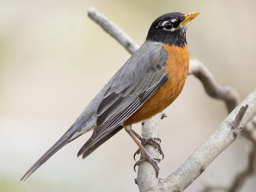

In [22]:
urls = search_images('robin photos', max_images=1)
dest = 'test.jpg'
download_url(urls[0], dest, show_progress=False)

from fastai.vision.all import *
im = Image.open(dest)
im.to_thumb(256,256)

In [23]:
is_bird,_,probs = learn.predict(PILImage.create('test.jpg'))
print(f"This is a: {is_bird}.")
print(f"Probability it's a bird: {probs[0]:.4f}")

This is a: bird.
Probability it's a bird: 1.0000
